# Dimsum Calibration

1. Use adaptive binning on STREUSLE validation set with consolidated labels.
2. Use the bin boundaries from the STREUSLE validation set to calibrate dimsum_test.

In [ ]:
# Notebook starts in notebooks folder. Change working directory back to streusle-tagger
%cd ../../../

In [2]:
import itertools
import math

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import numpy as np
import pandas as pd
import sklearn.metrics

%matplotlib inline

In [3]:
# Consolidated labelset
# validation_df = pd.read_csv("calibration/confidence_scores/validation/all_consolidated.csv")
# test_df = pd.read_csv("calibration/confidence_scores/test/all_consolidated.csv")
# dimsum_df = pd.read_csv("calibration/confidence_scores/dimsum_test/all_consolidated.csv")

In [4]:
# Consolidated labelset minus lexcat subtags
validation_df = pd.read_csv("calibration/confidence_scores/validation/all_consolidated_no_lexcat.csv")
test_df = pd.read_csv("calibration/confidence_scores/test/all_consolidated_no_lexcat.csv")
dimsum_df = pd.read_csv("calibration/confidence_scores/dimsum_test/all_consolidated_no_lexcat.csv")

In [5]:
def adaptive_binning(confidence_scores, labels, bin_size):
    """Assign (confidence_score, label) pairs to bins based on confidence_score."""
    
    num_bins = math.floor(len(confidence_scores) / bin_size)
    
    bins = []
    for i in range(num_bins):
        bins.append([])
    b = 0
    
    # Sort the data by score and put items in bins
    # Add integer index for recovering original order when measuring calibrated F1
    sorted_data = sorted(zip(confidence_scores, labels, list(range(len(confidence_scores)))), key=lambda x: x[0])
    for (score, label, index) in sorted_data:
        if len(bins[b]) < bin_size:
            bins[b].append((score, label, index))
        elif b == num_bins - 1:
            bins[b].append((score, label, index))
        else:
            b += 1
            bins[b].append((score, label, index))
    
    # print("Items in last bin: ", len(bins[-1]))
    
    return bins

def estimate_calibration_error(bins):
    """Estimate calibration error from binned confidence scores and labels."""
    bin_square_errors = []
    average_scores = []
    average_labels = []
    square_errors = []
    for i, bin_i in enumerate(bins):
        average_score = sum([x for (x, y, z) in bin_i]) / len(bin_i)
        average_label = sum([y for (x, y, z) in bin_i]) / len(bin_i)
        average_scores.append(average_score)
        average_labels.append(average_label)
        square_error = (average_score - average_label) ** 2
        square_errors.append(square_error)
        bin_square_errors.append(len(bin_i) * square_error)
        
    calibration_error = math.sqrt(np.mean(bin_square_errors))
    return average_scores, average_labels, calibration_error

def histogram_binning(confidence_scores, labels, bin_boundaries):
    """Bins confidence scores from second dataset according to boundaries determined in first dataset."""
    
    sorted_data = sorted(zip(confidence_scores, labels, list(range(len(confidence_scores)))), key=lambda x: x[0])
    
    num_bins = len(bin_boundaries)
    bins = []
    for i in range(num_bins):
        bins.append([])
    b = 0
    bin_boundaries[-1][1] = 999
    bin_boundaries[0][0] = -1
    start_bin = 0
    for j, (score, label, cell_id) in enumerate(sorted_data):
        for i, (low, high, _) in enumerate(bin_boundaries[start_bin:]):
            # Handle case where low equals high
            if low == high:
                if len(bins[i + start_bin] < bin_size):
                    bins[i + start_bin].append((score, label, cell_id))
                    start_bin = start_bin + i
            elif score >= low and score < high:
                bins[i + start_bin].append((score, label, cell_id))
                start_bin = start_bin + i
                break
    return bins

### Binning STREUSLE validation confidence scores

In [6]:
labelset = validation_df.columns[6:]
label_to_index = dict(zip(labelset, list(range(len(labelset)))))

validation_confidence_scores = []
validation_labels = []

for i, row in validation_df.iterrows():
    confidence_scores = row[6:]
    label = row[4]
    label_index = label_to_index[label]
    binary_labels = np.zeros(len(labelset))
    binary_labels[label_index] = 1
    validation_confidence_scores.append(list(confidence_scores))
    validation_labels.append(list(binary_labels))
    
# These are both lists of lists. Flatten into single list.
validation_confidence_scores = list(itertools.chain(*validation_confidence_scores))
validation_labels = list(itertools.chain(*validation_labels))

In [7]:
def get_bin_metadata(bins, average_labels):
    bin_info = []
    for i, b in enumerate(bins):
        scores = list(zip(*b))[0]
        try:
            if i == 0:
                bin_info.append([-1, max(scores), average_labels[i]])
            else:
                bin_info.append([bin_info[i - 1][1], max(scores), average_labels[i]])

        except:
            print(bin_info[i-1])

    return bin_info
    

In [8]:
def calibrated_f1(confidence_scores, target_df):
    ground_indexes = []
    for x in target_df["Ground Index"]:
        if x != -1:
            ground_indexes.append(x)
    
    flattened_confidence_scores = list(itertools.chain(*confidence_scores))
    scores_by_index = list(sorted(flattened_confidence_scores, key=lambda x: x[2]))
    
    scores = list(zip(*scores_by_index))[0]
    scores = np.array(scores).reshape(-1, len(labelset))

    denominators = scores.sum(axis=1)
    
    # Calibrated scores don't sum to 1, so normalize
    normalized_rows = []
    for i in range(len(ground_indexes)):
        normalized_row = [scores[i][j] / denominators[i] for j in range(len(labelset))]
        normalized_rows.append(normalized_row)

    # New prediction is max of calibrated score
    predicted_indexes = np.argmax(np.array(normalized_rows), axis=1)

    
            
    return sklearn.metrics.f1_score(ground_indexes, predicted_indexes, average="micro")

def f1(target_df):
    predicted_indexes = []
    for i, x, in enumerate(target_df["Predicted Index"]):
        if target_df.iloc[i][5] != -1:
            predicted_indexes.append(x)
    
    ground_indexes = []
    for x in target_df["Ground Index"]:
        if x != -1:
            ground_indexes.append(x)
            
    return sklearn.metrics.f1_score(ground_indexes, predicted_indexes, average="micro")

In [9]:
def graph(average_scores, average_labels, title):
    fig, ax = plt.subplots()
    plt.scatter(average_scores, average_labels)
    plt.title(title)
    line = mlines.Line2D([0, 1], [0, 1], color='red')
    transform = ax.transAxes
    ax.set_ylabel('Average Label of Bin')
    ax.set_xlabel('Average Confidence Score of Bin')
    line.set_transform(transform)
    ax.add_line(line)

def calibrate(dataset_name, target_df, bin_size):
    validation_bins = adaptive_binning(validation_confidence_scores, validation_labels, bin_size)
    validation_average_scores, validation_average_labels, validation_calibration_error = estimate_calibration_error(validation_bins)
    
    print("Streusle validation set calibration error: ", validation_calibration_error)
    
    bin_info = get_bin_metadata(validation_bins, validation_average_labels)
    
    confidence_scores = []
    labels = []
    
    for i, row in target_df.iterrows():
        label_index = row[5]
        
        if label_index == -1:
            continue
        
        row_confidence_scores = row[6:]
        binary_labels = np.zeros(len(labelset))
        binary_labels[label_index] = 1
        confidence_scores.append(list(row_confidence_scores))
        labels.append(list(binary_labels))
        
    # These are both lists of lists. Flatten into single list.
    confidence_scores = list(itertools.chain(*confidence_scores))
    labels = list(itertools.chain(*labels))

    target_bins = histogram_binning(confidence_scores, labels, bin_info)

    target_average_scores, target_average_labels, target_uncalibrated_ce = estimate_calibration_error(target_bins)

    calibrated_confidence_scores = []

    for i, b in enumerate(target_bins):
        bin_scores = [bin_info[i][2]] * len(b)
        bin_labels = list(zip(*b))[1]
        score_ids = list(zip(*b))[2]
        calibrated_confidence_scores.append(list(zip(bin_scores, bin_labels, score_ids)))
        
    calibrated_average_scores, calibrated_average_labels, calibrated_ce = estimate_calibration_error(calibrated_confidence_scores)
    
    graph(target_average_scores, target_average_labels, f"{dataset_name} Pre-Calibration Error (bin size = {bin_size})")
    graph(calibrated_average_scores, calibrated_average_labels, f"{dataset_name} Post-Calibration Error (bin size = {bin_size})")
    
    
    # Calibration error on target dataset when it get to use its own bin boundaries instead of the STREUSLE boundaries.
    # Oracle isn't a perfect word to describe this, but it's close enough.
    oracle_bins = adaptive_binning(confidence_scores, labels, bin_size)
    oracle_average_scores, oracle_average_labels, oracle_calibration_error = estimate_calibration_error(oracle_bins)
    
    print(f"Calibration Error (uncalibrated, oracle): {oracle_calibration_error}")
    print(f"Calibration Error (uncalibrated): {target_uncalibrated_ce}, F1: {f1(target_df)}")
    print(f"Calibration Error (calibrated): {calibrated_ce}, F1: {calibrated_f1(calibrated_confidence_scores, target_df)}")

### STREUSLE Test Calibration

Streusle validation set calibration error:  0.06954592234649323
Calibration Error (uncalibrated, oracle): 0.07781395257470461
Calibration Error (uncalibrated): 0.07892310467096067, F1: 0.8476119680356811
Calibration Error (calibrated): 0.0635281395843343, F1: 0.835160750789816

Streusle validation set calibration error:  0.07736545110776485
Calibration Error (uncalibrated, oracle): 0.08487396810549744
Calibration Error (uncalibrated): 0.08532237285362564, F1: 0.8476119680356811
Calibration Error (calibrated): 0.06162618616213634, F1: 0.8355324289165581

Streusle validation set calibration error:  0.08451208470806046
Calibration Error (uncalibrated, oracle): 0.09520319929121104
Calibration Error (uncalibrated): 0.09427368280520668, F1: 0.8476119680356811
Calibration Error (calibrated): 0.05413704670103918, F1: 0.8342315554729605

Streusle validation set calibration error:  0.09085701835359489
Calibration Error (uncalibrated, oracle): 0.10188315063370032
Calibration Error (uncalibrated):

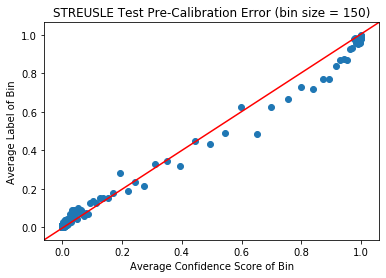

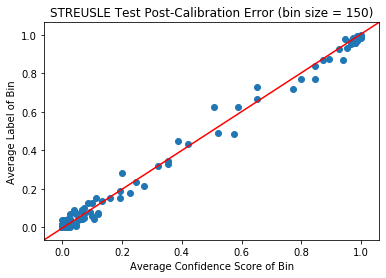

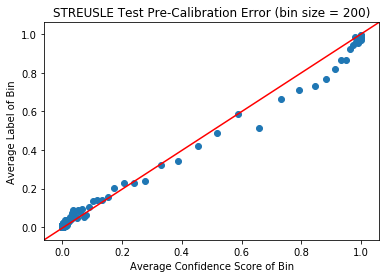

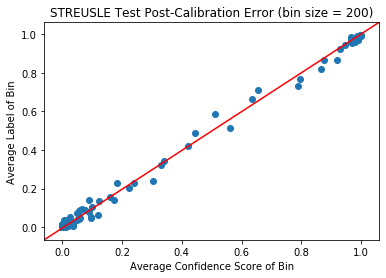

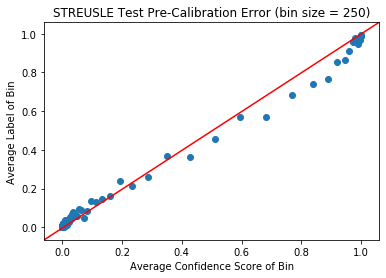

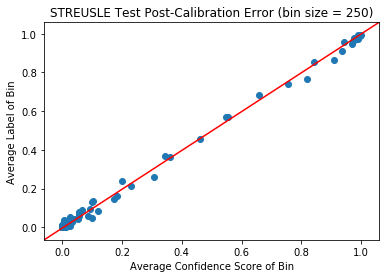

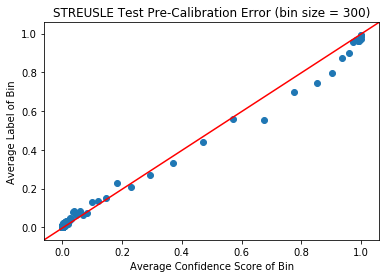

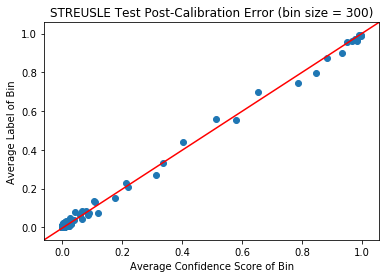

In [10]:
calibrate("STREUSLE Test", test_df, 150)
print()
calibrate("STREUSLE Test", test_df, 200)
print()
calibrate("STREUSLE Test", test_df, 250)
print()
calibrate("STREUSLE Test", test_df, 300)

### DiMSUM Test Calibration

Streusle validation set calibration error:  0.06954592234649323
Calibration Error (uncalibrated, oracle): 0.14091078082174613
Calibration Error (uncalibrated): 0.2333628329447457, F1: 0.7542285541073053
Calibration Error (calibrated): 0.1528544652305877, F1: 0.7456198848135799

Streusle validation set calibration error:  0.07736545110776485
Calibration Error (uncalibrated, oracle): 0.16007960360228446
Calibration Error (uncalibrated): 0.26636438018394526, F1: 0.7542285541073053
Calibration Error (calibrated): 0.16809876151155484, F1: 0.746711124583207

Streusle validation set calibration error:  0.08451208470806046
Calibration Error (uncalibrated, oracle): 0.17788352784551242
Calibration Error (uncalibrated): 0.29883550337667814, F1: 0.7542285541073053
Calibration Error (calibrated): 0.17857336759512302, F1: 0.7471354956047287

Streusle validation set calibration error:  0.09085701835359489
Calibration Error (uncalibrated, oracle): 0.191977754472032
Calibration Error (uncalibrated): 0.

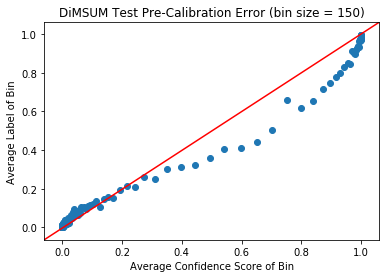

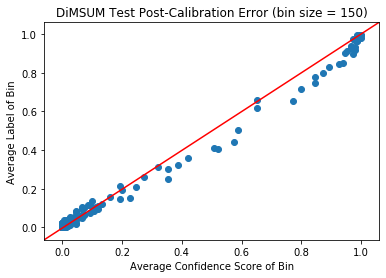

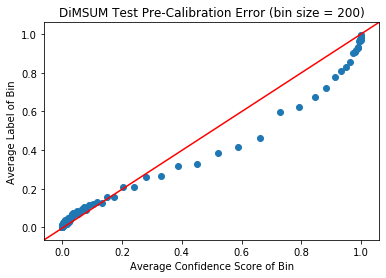

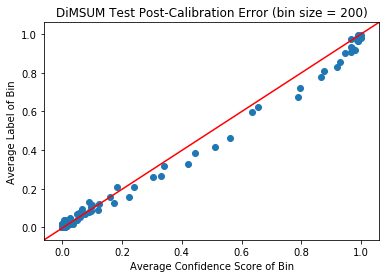

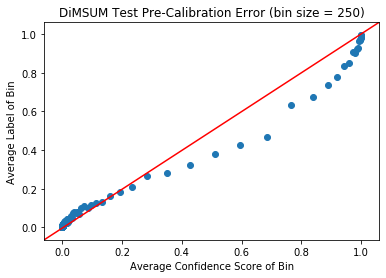

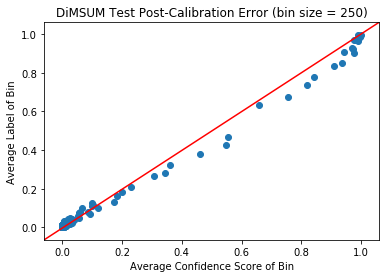

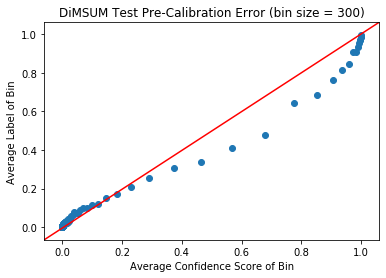

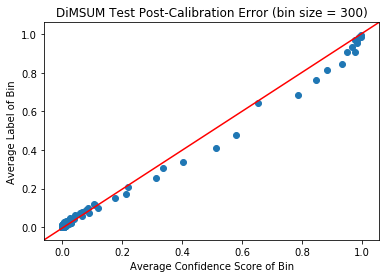

In [11]:
calibrate("DiMSUM Test", dimsum_df, 150)
print()
calibrate("DiMSUM Test", dimsum_df, 200)
print()
calibrate("DiMSUM Test", dimsum_df, 250)
print()
calibrate("DiMSUM Test", dimsum_df, 300)